In [7]:
import numpy as np
import cv2

# Add any python libraries here
import glob
import sys
import argparse
from matplotlib import pyplot as plt
from skimage.feature import corner_peaks
from typing import List

#Helper funcs
def cvt_for_plt(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def make_subplots(row_length,images):
    if len(images)%5 == len(images):
        fig,axs = plt.subplots(len(images))
        fig.set_size_inches(16,16)
        axs = axs.ravel()    
    else:
        fig,axs = plt.subplots(len(images)%5,len(images))

    for i,image in enumerate(images):
            axs[i].imshow(cvt_for_plt(image))

def embed_corners(img,corner_score_img=None,points=None):
    if corner_score_img is None and points is None:
        return
    img_corners = np.copy(img)
    if corner_score_img is not None:
        img_corners[corner_score_img>0.01*corner_score_img.max()] = [0,0,255]
        print(np.sum(corner_score_img>0.01*corner_score_img.max()))
    elif points is not None:
        print(np.shape(points))
        img_corners[tuple(points.T)] = [0,0,255]
    return img_corners

def embed_and_plot_corners(color_images,images_corner_score=None,images_corner_points=None):
    if images_corner_score is None and images_corner_points is None:
        return
    corner_embed_images = []
    if images_corner_score is not None:
        for i in range(len(color_images)):
            corner_embed_images.append(embed_corners(color_images[i],corner_score_img=images_corner_score[i]))
    elif images_corner_points is not None:
        for i in range(len(color_images)):
            corner_embed_images.append(embed_corners(color_images[i],points=images_corner_points[i]))
    make_subplots(5,corner_embed_images)
    

    

#Parameters
## corner Detection
ch_block_size = 5
ch_ksize = 9
ch_k = 0.0006
anms_local_maxima_threshold = 0.01

['../Data/Train/Set1/1.jpg', '../Data/Train/Set1/2.jpg', '../Data/Train/Set1/3.jpg']
(3, 450, 600, 3)


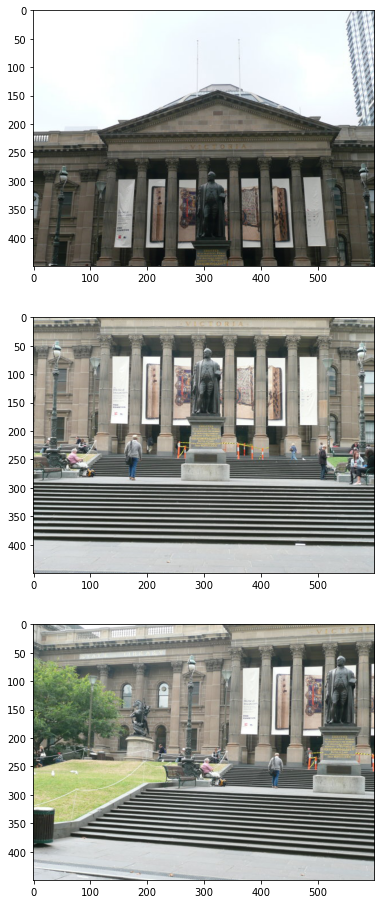

In [2]:
base_path = '../Data/Train/'
img_set = 'Set1/'
img_sequence = '2'
files = []

for file in glob.glob(base_path + img_set + "*.jpg",recursive=False):
    files.append(file.replace("\\","/"))
print(files)
# images_color = np.array(shape=(1len(files))
images_color = []
images_gray = []
for image_file in files:
    img_color_orig = cv2.imread(image_file)
    img_gray = cv2.cvtColor(img_color_orig,cv2.COLOR_BGR2GRAY)
    images_color.append(img_color_orig)
    images_gray.append(img_gray)

images_color = np.array(images_color)
print(images_color.shape)
make_subplots(len(files),images_color)

10337
11324
9406


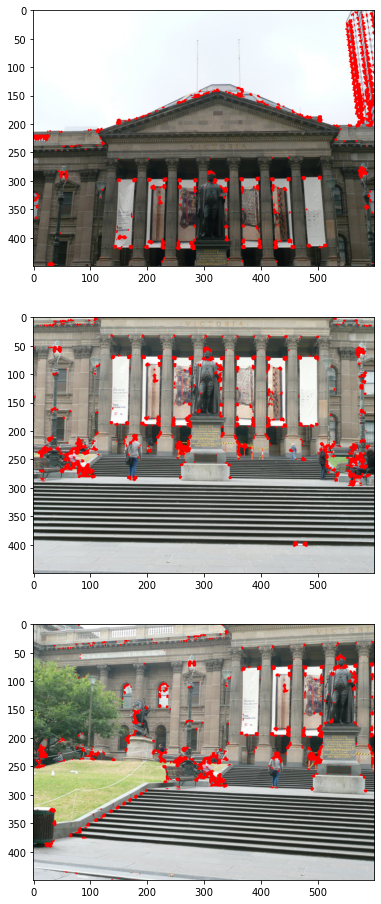

In [3]:

cornersOfImages = []
n_harris_corners_images = []
for i,image in enumerate(images_gray):
    cornersOfImg = cv2.cornerHarris(image,ch_block_size,ch_ksize,ch_k) ### TODO need to try out Shi-Tomasi Corner Detection instead
    n_harris_corners = np.sum(cornersOfImg>0.01*cornersOfImg.max())
    
    cornersOfImages.append(cornersOfImg)
    n_harris_corners_images.append(n_harris_corners)

embed_and_plot_corners(images_color,cornersOfImages)
    


In [4]:
## ANMS
from functools import total_ordering


@total_ordering
class CoOrds:
    def __init__(self,x,y):
        self.x = int(x)
        self.y = int(y)
        self.distance_score = sys.float_info.max
    def __lt__(self,obj):
        return ((self.distance_score) < (obj.distance_score))
    def __repr__(self) -> str:
        return "(x,y,distance):("+str(self.x)+","+str(self.y)+","+str(self.distance_score)+")"

def apply_anms_to_img(corner_score_img,n_best,anms_local_maxima_threshold):
    "input: "
    "output: numpy array of coordinates"
    local_maxima_coords = corner_peaks(corner_score_img,indices=True,threshold_abs=anms_local_maxima_threshold)

    # initializing distances array
    distances = np.full(local_maxima_coords.shape[0],fill_value=CoOrds(0,0))
    for i,coords in enumerate(local_maxima_coords):
        distances[i] = CoOrds(coords[0],coords[1])


    ED = None
    for i,coord_i in enumerate(local_maxima_coords):
        for coord_j in local_maxima_coords:
            # print(i," ", corner_score_img[coord_j[0],coord_j[1]], " ", corner_score_img[coord_i[0],coord_i[1]])
            if (corner_score_img[coord_j[0],coord_j[1]] > corner_score_img[coord_i[0],coord_i[1]]):
                ED = np.power((coord_j[0] - coord_i[0]),2) + np.power((coord_j[1]-coord_i[1]),2)
            if ED is not None and ED < distances[i].distance_score:
                distances[i].distance_score = ED
    sort_distances_obj = np.array(sorted(distances,reverse=True))
    print(sort_distances_obj.shape)
    sort_distances_obj = sort_distances_obj[0:n_best]
    
    
    sorted_dists_mat = np.zeros(shape=(sort_distances_obj.shape[0],2)) 

    for i,dist in enumerate(sort_distances_obj):
        sorted_dists_mat[i] = np.array([int(sort_distances_obj[i].x), sort_distances_obj[i].y])
    return sorted_dists_mat.astype(int)

anms_distances = []
for i in range(len(images_color)):
    anms_distances.append(apply_anms_to_img(cornersOfImages[i],int(n_harris_corners_images[i]/1),anms_local_maxima_threshold))


# print(cornersOfImg[240:250,290:310])

(2993,)
(3718,)
(4090,)


(2993, 2)
(3718, 2)
(4090, 2)


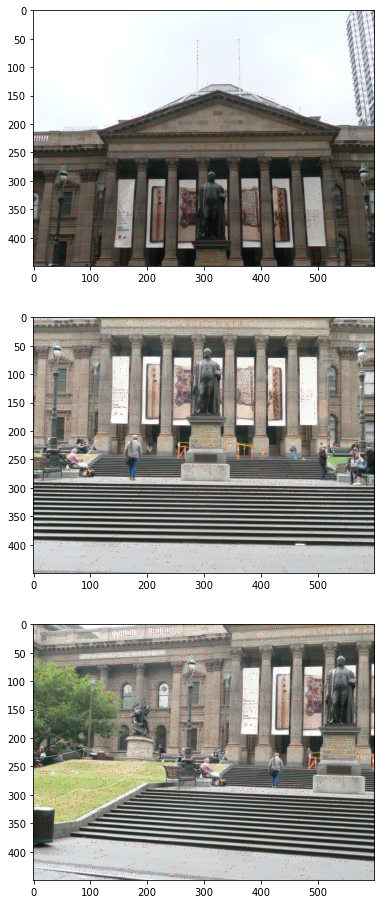

In [5]:
embed_and_plot_corners(images_color,images_corner_points=anms_distances)

In [8]:
def get_corner_descriptors(img_gray: List[List], corner_locs: np.array(List[List])) -> List[List]:
    """
    Returns descriptor list for all corner locations in image
    """
    corner_descriptors = []
    for (x, y) in corner_locs:
        corner_patch = img_gray[x-20:x+20, y-20:y+20]
        corner_patch = cv2.GaussianBlur(corner_patch, (5, 5), 0)
        corner_patch = cv2.resize(corner_patch, (8, 8), interpolation=cv2.INTER_AREA)
        corner_descriptors.append(corner_patch.flatten())
    return corner_descriptors